In [355]:
import numpy as np
import matplotlib.pyplot as plt
import control
import do_mpc

## Dynamics

Let's create a time marching simulation for a single-input single-output linear dynamical system.

In [356]:
A = np.array([[-0.1, 0.9], [0, -0.4]])
B = np.array([[0],[1]])
C = np.array([0,1])
D = 0

## Simulation

In [357]:
sys = control.ss(A, B, C, D)

In [358]:
T, yout, xout = control.step_response(sys, 50, [0,0], return_x=True)

## Plots

Plot the response for this system.

Text(0.5, 0, 'time')

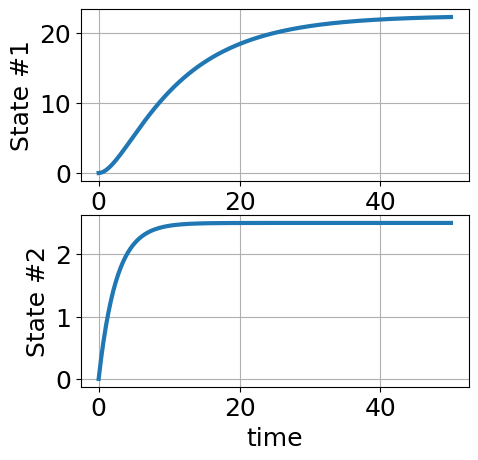

In [359]:
fig = plt.figure(dpi=100, figsize=(5, 5))
plt.subplot(2, 1, 1)
plt.plot(T, xout[0].flatten())
plt.ylabel('State #1')
plt.subplot(2,1,2)
plt.plot(T, xout[1].flatten())
plt.ylabel('State #2')
plt.xlabel("time")



## Settling times?

This is 3 time constants where the time constant is given by $\frac{1}{Re(pole)}$.

In [360]:
e, ev = np.linalg.eig(A)
settling_times =  3/abs(np.real(e))
print(f"The settling time of the system are {settling_times[0]} and {settling_times[1]}")

The settling time of the system are 30.0 and 7.5


Makes sense from the plot?

In [361]:
sysd =  control.c2d(sys, 0.1)
Ad, Bd, Cd, Dd = sysd.A, sysd.B, sysd.C, sysd.D

The type of model used (Discrete or Continuous)

In [362]:
model_type = "continuous"
model = do_mpc.model.Model(model_type)

Model Variables: States and Control Inputs

Can be vectors too. 

In [363]:
phi = model.set_variable(var_type = "_x", var_name="phid", shape = (2,1))
u = model.set_variable(var_type="_u", var_name="u", shape = (1,1))

In [364]:
model.u['u']

SX(u)

In [365]:
model.x.keys()

['phid']

In [366]:
model.x.labels()

['[phid,0]', '[phid,1]']

In [367]:
from casadi import *

In [368]:
model.set_rhs('phid', A @ phi + B @ u)

In [369]:
model.setup()


In [370]:
mpc = do_mpc.controller.MPC(model)


In [371]:
setup_mpc = {
    'n_horizon': 20,
    't_step': 0.1,
    'n_robust': 1,
    'store_full_solution': True,
}
mpc.set_param(**setup_mpc)

In [372]:
mterm = phi.T @ phi
lterm = phi.T @ phi

In [373]:
mpc.set_objective(mterm=mterm, lterm=lterm)


In [374]:
mpc.bounds['lower','_x', 'phid'] = [-2*np.pi, -2]

In [375]:
mpc.setup()


C:\ProgramData\Anaconda3\lib\site-packages\do_mpc\controller.py:904: UserWarning: rterm was not set and defaults to zero. Changes in the control inputs are not penalized. Can lead to oscillatory behavior.
  warnings.warn('rterm was not set and defaults to zero. Changes in the control inputs are not penalized. Can lead to oscillatory behavior.')


In [376]:
simulator = do_mpc.simulator.Simulator(model)
simulator.set_param(t_step = 0.1)


In [377]:
x0 = np.pi*np.array([1, 1]).reshape(-1,1)
simulator.x0 = x0
mpc.x0 = x0

In [378]:
mpc.x0['phid']

DM([3.14159, 3.14159])

In [379]:
mpc.set_initial_guess()

In [380]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# Customizing Matplotlib:
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.grid'] = True
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
sim_graphics = do_mpc.graphics.Graphics(simulator.data)

In [381]:
%%capture
# We just want to create the plot and not show it right now. This "inline magic" supresses the output.
fig, ax = plt.subplots(2, sharex=True, figsize=(10,9))
fig.align_ylabels()

In [382]:
%%capture
for g in [sim_graphics, mpc_graphics]:
    # Plot the angle positions (phi_1, phi_2, phi_2) on the first axis:
    g.add_line(var_type='_x', var_name='phid', axis=ax[0])

    # # Plot the set motor positions (phi_m_1_set, phi_m_2_set) on the second axis:
    g.add_line(var_type='_u', var_name='u', axis=ax[1])
    # g.add_line(var_type='_u', var_name='phi_m_2_set', axis=ax[1])


ax[0].set_ylabel('States')
ax[1].set_ylabel('Inputs')
ax[1].set_xlabel('time [s]')

In [383]:
u0 = np.zeros((1,1))
simulator.setup()
for i in range(200):
    simulator.make_step(u0)

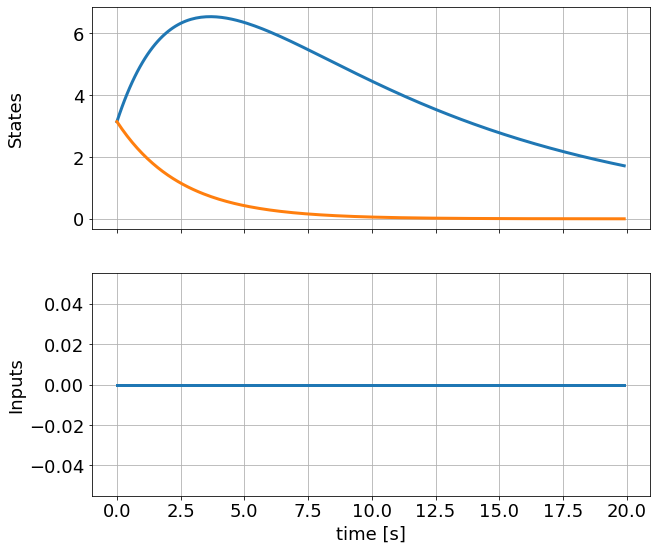

In [384]:
sim_graphics.plot_results()
# Reset the limits on all axes in graphic to show the data.
sim_graphics.reset_axes()
# Show the figure:
fig